In [2]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import csv
import pickle
import pylab

import numpy as np
import scipy as sc
import pandas as pd
import editdistance

import torch

import rna
import models
import utils
import vae
import designers

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

In [17]:
reload(rna)
n_train = 5000
p_mutation = 4 / 50
noise_sd = 0.03
n_hidden = 100
n_epoch = 5
lr = 0.001
n_filters = 32
save_fname_no_ftype = 'nsd{:.2f}-h{}-032223'.format(noise_sd, n_hidden)

ridge, ff, cnn, testseq_n, ytest_n = rna.train_models(
    n_train,
    p_mutation=p_mutation,
    noise_sd=noise_sd,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    lr=lr,
    n_filters=n_filters,
    save_fname_no_ftype=save_fname_no_ftype,
)

Generating 5000 labeled sequences...
Done. (55 s)
Generating 5000 labeled sequences...
Done. (55 s)
CV-selected alpha for ridge: 10.0.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 120.13it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 109.43it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 108.92it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 108.64it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 110.91it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.42it/s]


Epoch 0. Train loss: 0.01. Val loss: 0.08. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.02it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.69it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.66it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 53.14it/s]

Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-nsd0.03-h100-032223.pt.
Saved FF model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-nsd0.03-h100-032223.pt.
Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-nsd0.03-h100-032223.pt.
Saved CNN model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-nsd0.03-h100-032223.pt.
Saved training data to /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.03-h100-032223.npz.


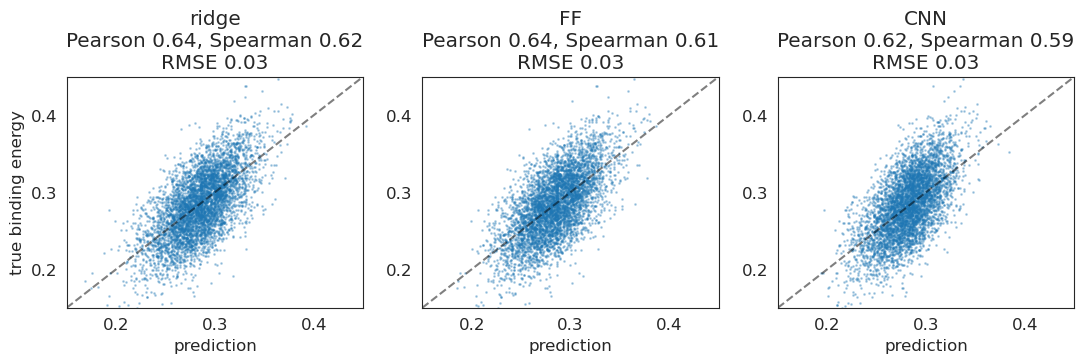

In [18]:
sns.set_style('white')
plt.figure(figsize=(13, 3))
xy_lim = [0.15, 0.45]
model_names = ['ridge', 'FF', 'CNN']

for i, model in enumerate([ridge, ff, cnn]):
    predtest_n = model.predict(testseq_n)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
    plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
    
    r, p = sc.stats.pearsonr(ytest_n, predtest_n)
    rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
    
    plt.ylim(xy_lim);
    plt.xlim(xy_lim)
    plt.title('{}\nPearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(model_names[i], r, rho, rmse));
    plt.xlabel('prediction');
    if i == 0: 
        plt.ylabel('true binding energy'); 

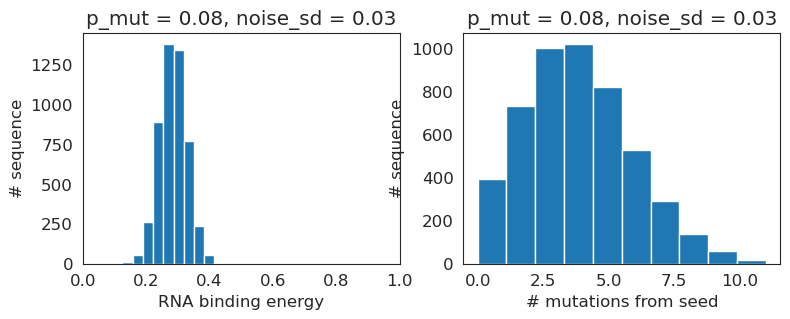

In [19]:
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(ytest_n)
plt.xlabel('RNA binding energy');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mutation, noise_sd));
plt.xlim([0, 1]);

plt.subplot(122)
testdist_n = [editdistance.eval(seq, rna.RNABinding.SEEDS[3]) for seq in testseq_n]
plt.hist(testdist_n)
plt.xlabel('# mutations from seed');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mutation, noise_sd));

In [ ]:
reload(rna)
# HERE: plot mean prediction vs. label and see!
# need to play with heteroskedastic noise to get more overprediction?

n_design = 50000
adalead_thresholds = [0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01]
biswas_temperatures = [1, 0.5, 0.1, 0.05, 0.01]
model_and_data_fname_no_ftype = 'nsd{:.2f}-h{}-032223'.format(noise_sd, n_hidden)
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-nsd{:.2f}-h{}-032223.pkl'.format(noise_sd, n_hidden)

name2designs = rna.sample_design_sequences(
    n_design,
    adalead_thresholds,
    biswas_temperatures,
    model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
    design_pkl_fname=design_pkl_fname
)

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.03-h100-032223.npz.

Saving all results to /homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-nsd0.03-h100-032223.pkl.

Designing AdaLead threshold = 0.9 ridge sequences...
Designed 20000 / 100000 candidates (34 s).
Designed 40000 / 100000 candidates (76 s).
Designed 60000 / 100000 candidates (129 s).
Designed 80000 / 100000 candidates (185 s).
Designed 100000 / 100000 candidates (256 s).
  Done. (263 s)
  Mean label, prediction: 0.316, 0.318
  Saved 50000 AdaLead threshold = 0.9 ridge sequences.

Designing AdaLead threshold = 0.7 ridge sequences...
Designed 20000 / 100000 candidates (34 s).
Designed 40000 / 100000 candidates (78 s).
Designed 60000 / 100000 candidates (133 s).
Designed 80000 / 100000 candidates (193 s).
Designed 100000 / 100000 candidates (267 s).
  Done. (274 s)
  Mean label, prediction: 0.315, 0.317
  Saved 50000 AdaLead threshold = 0.7 ridge sequ

In [420]:
with open(design_pkl_fname, 'rb') as f:
    loaded_name2designs = pickle.load(f)

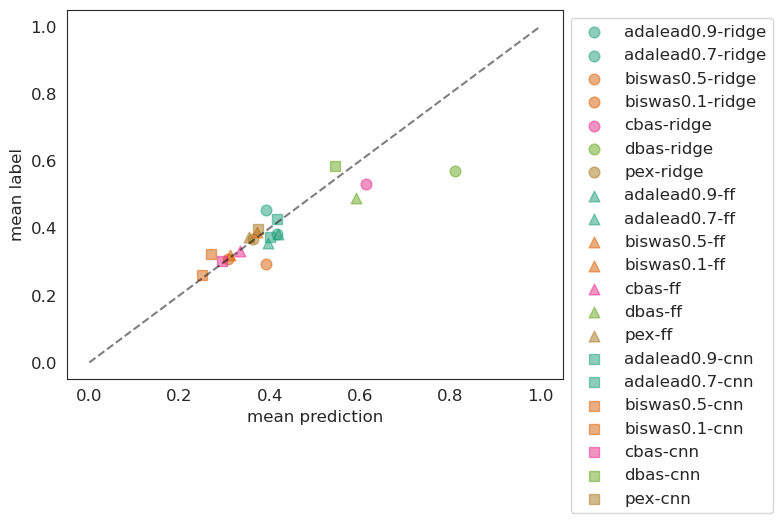

In [435]:
cm = pylab.get_cmap('Dark2')
def name2color(name):
    if 'adalead' in name:
        return cm(0)
    if 'biswas' in name:
        return cm(1 / 5)
    if 'cbas' in name:
        return cm(2 / 5)
    if 'dbas' in name:
        return cm(3 / 5)
    if 'pex' in name:
        return cm(4 / 5)
def name2marker(name):
    if 'ridge' in name:
        return 'o'
    if 'ff' in name:
        return '^'
    if 'cnn' in name:
        return 's'
    
for i, (name, designs) in enumerate(loaded_name2designs.items()):
    seq_n, y_n, pred_n = designs
    plt.scatter(pred_n, y_n, label=name, s=60, alpha=0.5, color=name2color(name), marker=name2marker(name))
    
plt.plot([0, 1], [0, 1], '--k', alpha=0.5)
plt.xlabel('mean prediction');
plt.ylabel('mean label');
plt.legend(bbox_to_anchor=(1, 1), fontsize=10);

# VAE

In [188]:
# generate training data
reload(rna)
n_train = 10000
p_mut = 0.1
noise_sd = 0.02

rnabind = rna.RNABinding()
trainseq_n, ytrain_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)
predtrain_n = model.predict(trainseq_n)

Generating 10000 labeled sequences...
Done. (110 s)


One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 38.8046, KL: 1.4174, CE: 37.3871. Val loss: 50.5612, KL: 0.0927, CE: 50.4685. (4 s)
Epoch 1. Train loss: 27.2079, KL: 0.1930, CE: 27.0149. Val loss: 21.9387, KL: 0.2615, CE: 21.6772. (4 s)
Epoch 2. Train loss: 26.4693, KL: 0.0467, CE: 26.4227. Val loss: 20.9355, KL: 0.0414, CE: 20.8941. (4 s)
Epoch 3. Train loss: 26.2258, KL: 0.0303, CE: 26.1955. Val loss: 21.5191, KL: 0.0210, CE: 21.4980. (4 s)
Epoch 4. Train loss: 26.2559, KL: 0.0288, CE: 26.2271. Val loss: 22.2393, KL: 0.0158, CE: 22.2235. (4 s)
Epoch 5. Train loss: 26.2686, KL: 0.0225, CE: 26.2460. Val loss: 21.5232, KL: 0.0132, CE: 21.5101. (4 s)
Epoch 6. Train loss: 25.9260, KL: 0.0200, CE: 25.9060. Val loss: 21.2425, KL: 0.0140, CE: 21.2284. (4 s)
Epoch 7. Train loss: 25.9936, KL: 0.0116, CE: 25.9821. Val loss: 21.4337, KL: 0.0119, CE: 21.4218. (4 s)
Epoch 8. Train loss: 26.0141, KL: 0.0122, CE

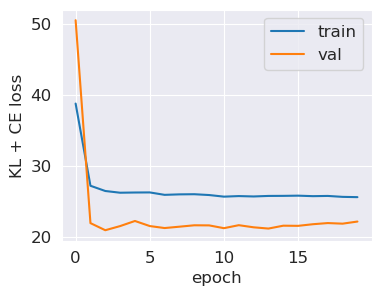

In [212]:
reload(vae)
latent_dim = 10
n_hidden = 20
lr = 0.001
n_epoch = 10

vae_model = vae.VAE(
    latent_dim=latent_dim,
    n_enc_hidden=n_hidden,
    n_dec_hidden=n_hidden
)

loss_df = vae_model.fit(
    trainseq_n,
    weight_n=np.fmax(predtrain_n - 0.35, 0),
    lr=lr,
    n_epoch=n_epoch
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df.index, loss_df['train_loss'], label='train')
plt.plot(loss_df.index, loss_df['val_loss'], label='val')
plt.xlabel('epoch');
plt.ylabel('KL + CE loss');
plt.legend();

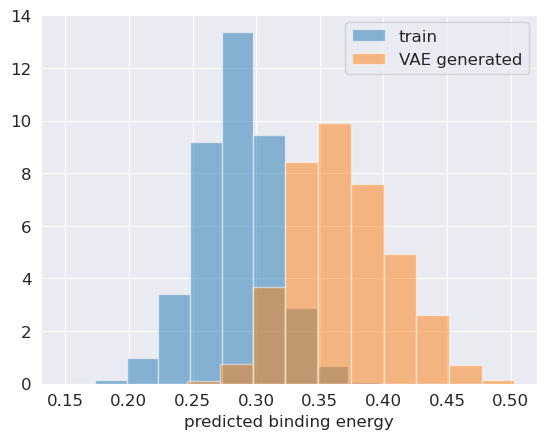

In [213]:
n_sample = 1000

genseq_n = vae_model.generate(n_sample)
ygen_n = rnabind.get_fitness(genseq_n)
predgen_n = model.predict(genseq_n)

plt.figure(figsize=(4, 3))
plt.hist(predtrain_n, alpha=0.5, density=True, label='train')
plt.hist(predgen_n, alpha=0.5, density=True, label='VAE generated')
plt.legend();
plt.xlabel('predicted binding energy');

## DbAS / CbAS

In [81]:
reload(vae)
reload(designers)

latent_dim = 10
n_hidden = 20
weight_type = 'cbas'
device = 'cpu'

cbas = designers.CbAS(
    model,
    trainseq_n,
    latent_dim=latent_dim,
    n_hidden=n_hidden,
    weight_type=weight_type,
    device=device
)

Fitting training distribution:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 28.1230, KL: 0.5998, CE: 27.5232. Val loss: 70.9554, KL: 0.1987, CE: 70.7567. (2 s)
Epoch 1. Train loss: 21.9098, KL: 0.0366, CE: 21.8732. Val loss: 21.9339, KL: 0.0443, CE: 21.8896. (2 s)
Epoch 2. Train loss: 21.7574, KL: 0.0614, CE: 21.6960. Val loss: 21.7558, KL: 0.0457, CE: 21.7101. (2 s)
Epoch 3. Train loss: 21.7133, KL: 0.0511, CE: 21.6623. Val loss: 21.6740, KL: 0.0581, CE: 21.6159. (2 s)
Epoch 4. Train loss: 21.6991, KL: 0.0421, CE: 21.6571. Val loss: 21.6495, KL: 0.0427, CE: 21.6068. (2 s)


In [83]:
n_design = 1000
quantile = 0.9
design_n = cbas.design_sequences(
    n_design,
    quantile=quantile
)

Fitting design distribution with quantile hyperparameter = 0.9:
Iter 0. Mean, SD, max prediction: 0.284, 0.029, 0.403. 998 valid samples for threshold 0.319. (3 s)
Iter 1. Mean, SD, max prediction: 0.310, 0.029, 0.412. 1000 valid samples for threshold 0.349. (7 s)
Iter 2. Mean, SD, max prediction: 0.327, 0.031, 0.456. 1000 valid samples for threshold 0.367. (11 s)
Iter 3. Mean, SD, max prediction: 0.341, 0.035, 0.466. 1000 valid samples for threshold 0.388. (15 s)
Iter 4. Mean, SD, max prediction: 0.341, 0.032, 0.453. 1000 valid samples for threshold 0.388. (19 s)
Iter 5. Mean, SD, max prediction: 0.350, 0.035, 0.476. 1000 valid samples for threshold 0.395. (23 s)
Iter 6. Mean, SD, max prediction: 0.356, 0.036, 0.492. 1000 valid samples for threshold 0.404. (27 s)
Iter 7. Mean, SD, max prediction: 0.362, 0.033, 0.496. 1000 valid samples for threshold 0.406. (31 s)
Iter 8. Mean, SD, max prediction: 0.365, 0.034, 0.483. 1000 valid samples for threshold 0.408. (35 s)
Iter 9. Mean, SD, max

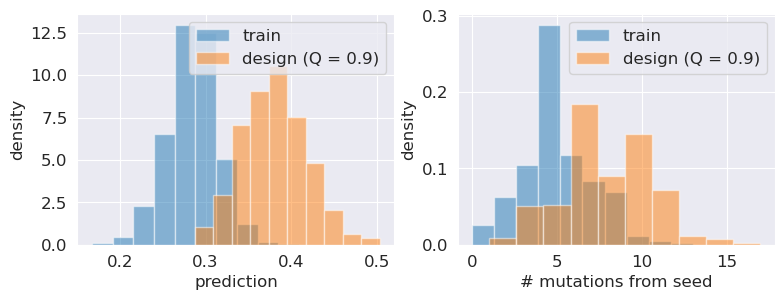

In [84]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design (Q = {})'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design (Q = {})'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

# PEX

In [129]:
reload(designers)
pex = designers.PEX(
    model,
    trainseq_n,
    ytrain_n,
    rnabind.SEEDS[3],
)

In [130]:
n_design = 5000
p_mutation = 2 / 50

design_n = pex.design_sequences(
    n_design,
    p_mutation,
)

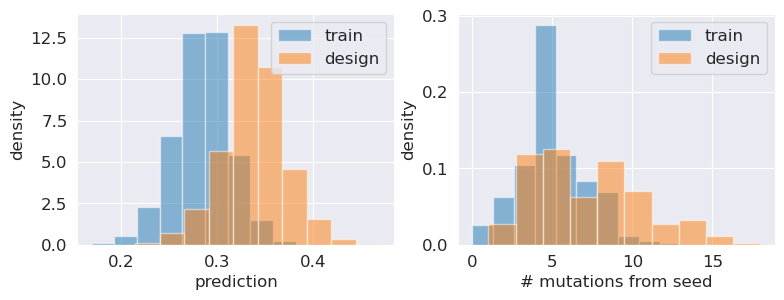

In [131]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

# AdaLead

In [298]:
reload(designers)

n_recomb_partner = 1
recomb_rate = 0.2
n_design = 5000
threshold = 0.05
print_every = 2000

adalead = designers.AdaLead(
    model,
    trainseq_n,
    ytrain_n
)
design_n = adalead.design_sequences(
    n_design=n_design,
    threshold=threshold,
    n_recomb_partner=n_recomb_partner,
    recomb_rate=recomb_rate,
    print_every=print_every
)

Designed 2000 / 10000 candidates (2 s).
Designed 4000 / 10000 candidates (6 s).
Designed 6000 / 10000 candidates (9 s).
Designed 8000 / 10000 candidates (12 s).
Designed 10000 / 10000 candidates (15 s).
5000


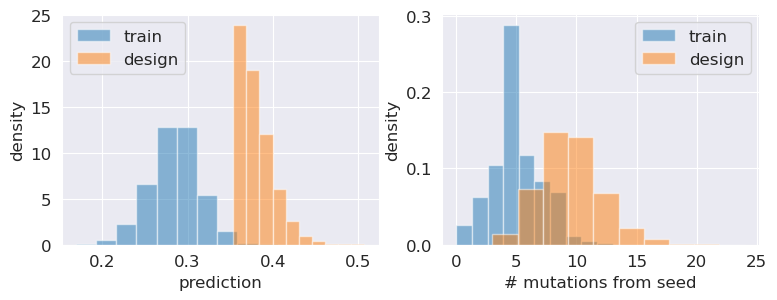

In [299]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

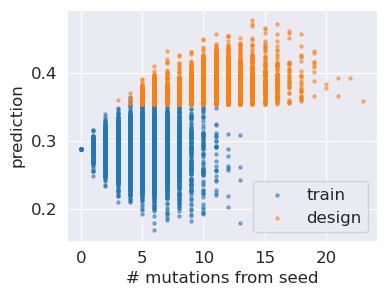

In [207]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(4, 3))
plt.scatter(disttrain_n, predtrain_n, alpha=0.5, label='train', s=5)
plt.scatter(distdesign_n, preddesign_n, alpha=0.5, label='design', s=5)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('prediction');


# Biswas

In [382]:
reload(designers)

n_design = 100
seed_seq = rnabind.SEEDS[3]
max_mu = 2
temperature = 0.005
n_trust_radius_mutations = 10
n_step = 10000
print_every = 500

biswas = designers.Biswas(model, trainseq_n)
design_n, pred_nxt1, acceptprob_nxt = biswas.design_sequences(
    n_design,
    seed_seq,
    max_mu,
    temperature,
    n_trust_radius_mutations,
    n_step,
    print_every
)

Initialization. Mean, SD prediction: 0.288, 0.028.
Step 500. Mean, SD acceptance probability: 0.048, 0.182. Mean, SD prediction: 0.448, 0.026. (2 s)
Step 1000. Mean, SD acceptance probability: 0.017, 0.104. Mean, SD prediction: 0.473, 0.032. (5 s)
Step 1500. Mean, SD acceptance probability: 0.030, 0.146. Mean, SD prediction: 0.490, 0.035. (8 s)
Step 2000. Mean, SD acceptance probability: 0.054, 0.199. Mean, SD prediction: 0.503, 0.034. (10 s)
Step 2500. Mean, SD acceptance probability: 0.035, 0.150. Mean, SD prediction: 0.513, 0.034. (13 s)
Step 3000. Mean, SD acceptance probability: 0.067, 0.210. Mean, SD prediction: 0.521, 0.035. (16 s)
Step 3500. Mean, SD acceptance probability: 0.058, 0.197. Mean, SD prediction: 0.529, 0.034. (18 s)
Step 4000. Mean, SD acceptance probability: 0.038, 0.172. Mean, SD prediction: 0.536, 0.031. (21 s)
Step 4500. Mean, SD acceptance probability: 0.023, 0.114. Mean, SD prediction: 0.540, 0.030. (24 s)
Step 5000. Mean, SD acceptance probability: 0.042, 0.

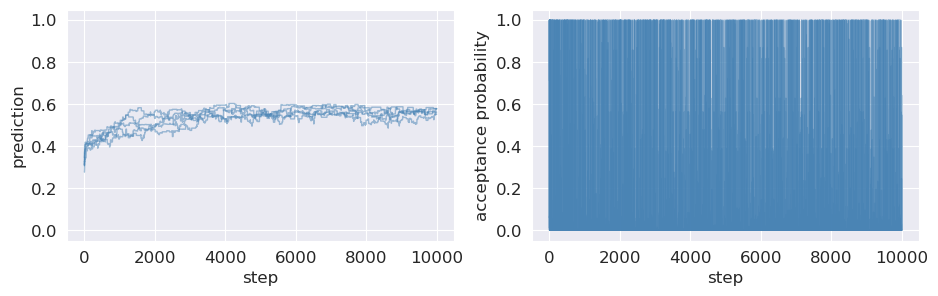

In [383]:
n_to_plot = 5
plt.figure(figsize=(11, 3))
plt.subplot(121)
plt.plot(pred_nxt1[: n_to_plot].T, linewidth=1, c='steelblue', alpha=0.5);
plt.ylim([-0.05, 1.05])
plt.xlabel('step');
plt.ylabel('prediction');

plt.subplot(122)
plt.plot(acceptprob_nxt[: n_to_plot].T, linewidth=1, c='steelblue', alpha=0.5);
plt.ylim([-0.05, 1.05])
plt.xlabel('step');
plt.ylabel('acceptance probability');

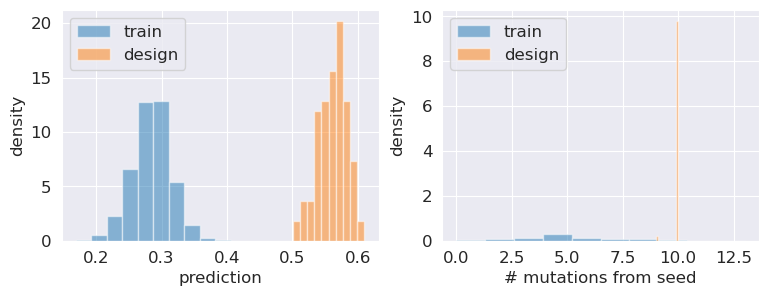

In [384]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

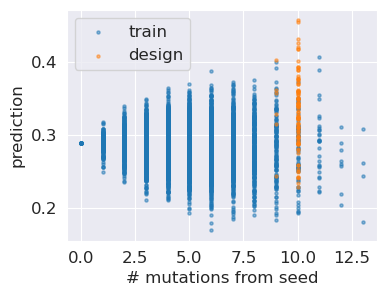

In [376]:
plt.figure(figsize=(4, 3))
plt.scatter(disttrain_n, predtrain_n, alpha=0.5, label='train', s=5)
plt.scatter(distdesign_n, preddesign_n, alpha=0.5, label='design', s=5)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('prediction');
